Công ty của bạn hiện nay đang muốn đẩy mạnh hoạt động kinh doanh bằng cách tập chung các chiến lược khác nhau cho các nhóm khách hàng khác nhau. Như vậy việc quan trọng là cần phân khách hàng thành các nhóm cụ thể dựa trên một số yếu tố nào đó. Nhiệm vụ của bạn là tìm các yếu tố đó và phân khách hàng vào các nhóm cụ thể

Bạn sẽ được cung cấp một bộ dữ liệu để thực hiện xây dựng mô hình phân nhóm khách hàng:

Thông tin các cột trong file dữ liệu:
* **InvoiceNo**: Id Hoá đơn
* **StockCode**: Id của các mặt hàng đã mua
* **Description**: Môt tả của mặt hàng
* **Quantity**: Số lượng của mặt hàng đã mua.
* **InvoiceDate**: Ngày mua
* **UnitPrice**: Giá của mặt hàng
* **CustomerID**: Id khách hàng đã mua hàng
* **Country**: Tên quốc gia của khách hàng



# 1. Import thư viện và tải dữ liệu

#### **Yêu cầu 1: Import thành công dữ liệu và thư viện**

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import datetime
import math
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import plotly as py
from sklearn.metrics import silhouette_samples, silhouette_score
import plotly.graph_objs as go
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
print('Import librarys successfully')

Import librarys successfully


Hàm dưới đây sẽ phục vụ cho việc vẽ các biểu đồ phân phối

In [2]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [3]:
df = pd.read_csv('Online Retail.csv')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 2. EDA

In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
# Kiểm tra xem có giao dịch nào có Quantity và UnitPrice đều nhỏ hơn 0 hay không:
negative_trans = len(df.loc[(df['Quantity'] < 0) & (df['UnitPrice'] < 0)])
print(f"Số giao dịch có Quantity và UnitPrice đều nhỏ hơn 0: {negative_trans}")

Số giao dịch có Quantity và UnitPrice đều nhỏ hơn 0: 0


In [7]:
# Kiểm tra xem có bao nhiêu giao dịch có Quantity < 0 và UnitPrice = 0 hoặc ngược lại
count_trans = len(df.loc[(df['Quantity'] < 0) & (df['UnitPrice'] == 0) | (df['Quantity'] == 0) & (df['UnitPrice'] < 0)])
print(f"Số giao dịch có Quantity < 0 và Unitpirce = 0 hoặc ngược lại: {count_trans}")

Số giao dịch có Quantity < 0 và Unitpirce = 0 hoặc ngược lại: 1336


In [8]:
# ID các khách hàng ở trong các giao dịch ở ý trên là gì:
customer_ids = df[((df['Quantity'] < 0) & (df['UnitPrice'] == 0)) | ((df['Quantity'] == 0) & (df['UnitPrice'] < 0))]['CustomerID'].unique()
print(f"ID các khách hàng ở trong các giao dịch ở ý trên: {customer_ids}")

ID các khách hàng ở trong các giao dịch ở ý trên: [nan]


In [9]:
# Tỷ lệ Quantity nhỏ hơn 0 trên tất cả các giao dịch
negative_quantity_ratio = (len(df.loc[df['Quantity'] < 0]) / len(df)) * 100
print(f"Tỷ lệ Quantity nhỏ hơn 0 trên tất cả các giao dịch là: {negative_quantity_ratio}")

Tỷ lệ Quantity nhỏ hơn 0 trên tất cả các giao dịch là: 1.9604767590130447


In [10]:
# Tất cả các giao dịch với Quantity âm đều có Hoá đơn bắt đầu bằng ký tự gì:
first_char_negative_quantity = df[df['Quantity'] < 0]['InvoiceNo'].str[0].unique()
print(f"Tất cả các giao dịch với Quantity âm đều có Hoá đơn bắt đầu bằng ký tự: {first_char_negative_quantity}")

Tất cả các giao dịch với Quantity âm đều có Hoá đơn bắt đầu bằng ký tự: ['C' '5']


In [5]:
cs_df = df.dropna(subset = ['CustomerID'])
cs_df = cs_df[cs_df['Quantity'] >= 0]
cs_df = cs_df[cs_df['UnitPrice'] > 0]
cs_df.shape

(397884, 8)

In [6]:
cs_df.InvoiceDate = pd.to_datetime(cs_df.InvoiceDate)
cs_df['amount'] = cs_df.Quantity*cs_df.UnitPrice
cs_df.CustomerID = cs_df.CustomerID.astype('Int64')
cs_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [13]:
# Xác định ngày tham chiếu cho phân tích(Ngày cuối cùng + thêm 1 ngày)
reference_date = cs_df['InvoiceDate'].max() + pd.DateOffset(days = 1)
print(f"Reference_date: {reference_date}")
# Tính Recency
recency = (reference_date - cs_df.groupby('CustomerID')['InvoiceDate'].max()).dt.days
customer_history_df = pd.DataFrame()
customer_history_df = recency.reset_index().rename(columns = {'InvoiceDate':"recency"})
customer_history_df.describe().transpose()

Reference_date: 2011-12-10 12:50:00


,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.0,51.0,142.0,374.0


#### **Yêu cầu 6. Trực quan hoá biến Recency bằng cách sử dụng Hàm QQ_plot**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10704\2679653009.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


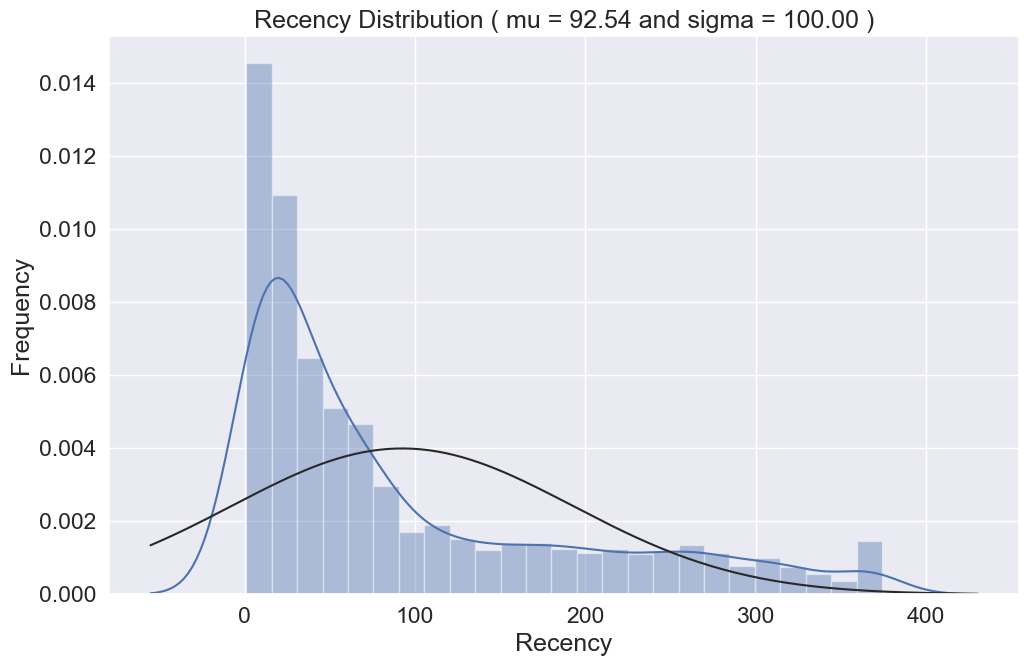

In [14]:
QQ_plot(customer_history_df['recency'], 'Recency')

Từ biểu trên, chúng ta có thể thấy rằng phân phối của Recency bị lệch, có đỉnh ở bên trái và đuôi dài ở bên phải. Nó lệch khỏi phân phối chuẩn và có xu hướng dương.


In [15]:
cs_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [16]:
frequency = cs_df.groupby('CustomerID')['InvoiceNo'].nunique()
customer_history_df['frequency'] = frequency.reset_index()['InvoiceNo']
customer_history_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.0,51.0,142.0,374.0
frequency,4338.0,4.272015,7.697998,1.0,1.0,2.0,5.0,209.0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10704\2679653009.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


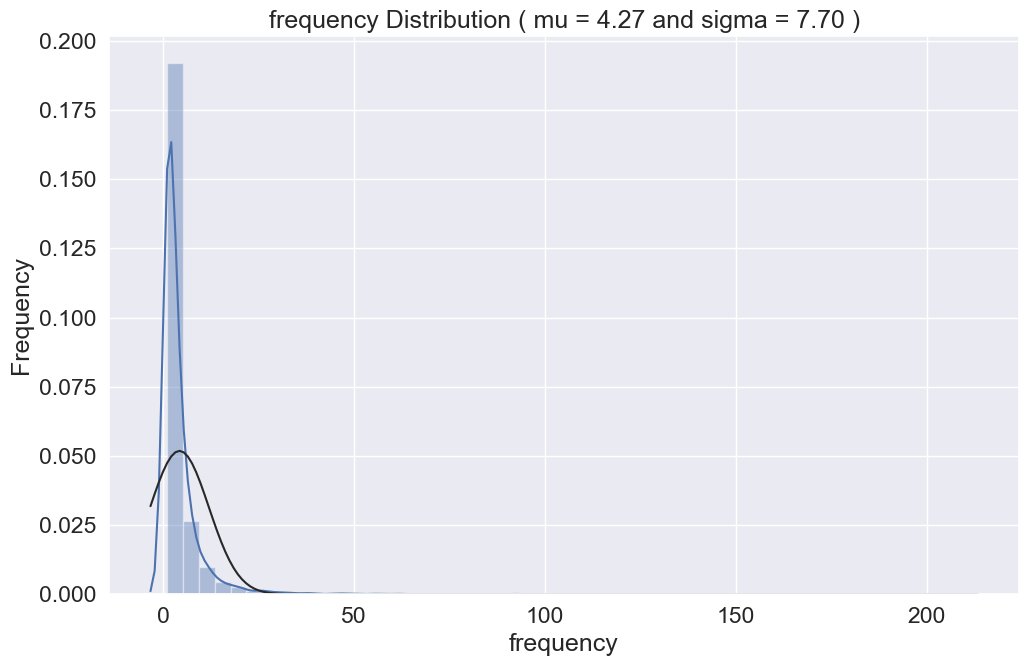

In [17]:
QQ_plot(customer_history_df['frequency'], 'frequency')

Từ biểu trên, chúng ta có thể thấy rằng phân phối tần suất bán hàng bị lệch, có đỉnh ở bên trái và đuôi dài ở bên phải. Nó lệch khỏi phân phối chuẩn và có xu hướng dương.

In [18]:
monetary = cs_df.groupby('CustomerID')['amount'].sum()
customer_history_df['amount'] = monetary.reset_index()['amount']
customer_history_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.0,51.0,142.0,374.0
frequency,4338.0,4.272015,7.697998,1.0,1.0,2.0,5.0,209.0
amount,4338.0,2054.26646,8989.230441,3.75,307.415,674.485,1661.74,280206.02


#### **Yêu cầu 10: Trực quan hoá Monetary Value với hàm QQ_plot**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10704\2679653009.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


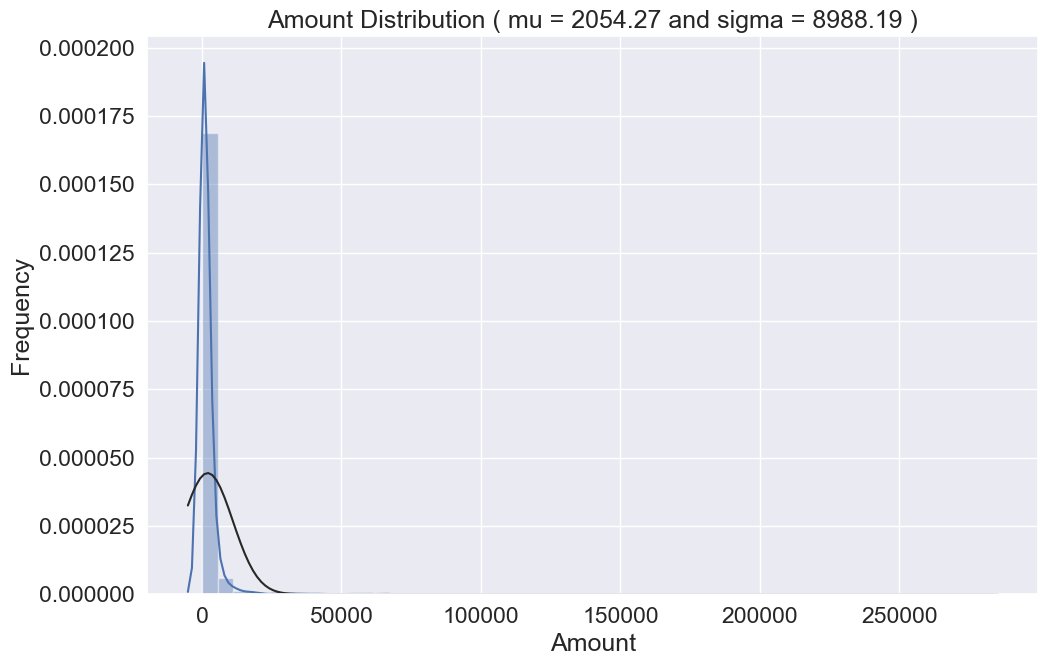

In [19]:
QQ_plot(customer_history_df['amount'], 'Amount')

Từ biểu trên, chúng ta có thể thấy rằng phân phối  Monetary Value bị lệch, có đỉnh ở bên trái và đuôi dài ở bên phải. Nó lệch khỏi phân phối chuẩn và có xu hướng dương.

In [20]:
customer_history_df.describe()

,CustomerID,recency,frequency,amount
count,4338.0,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.0,1.000000,1.000000,3.750000
25%,13813.25,18.000000,1.000000,307.415000
50%,15299.5,51.000000,2.000000,674.485000
75%,16778.75,142.000000,5.000000,1661.740000
max,18287.0,374.000000,209.000000,280206.020000



#### Scaler Data


In [21]:
customer_history_df[['recency_log', 'frequency_log', 'amount_log']] = customer_history_df[['recency', 'frequency', 'amount']].applymap(lambda x : np.log(x))
scaler = StandardScaler()
scaler.fit(customer_history_df[['amount_log', 'recency_log', 'frequency_log']])
scaler_data = scaler.transform(customer_history_df[['amount_log', 'recency_log', 'frequency_log']])

df_scaler = pd.DataFrame(data = scaler_data, columns = ['amount_log', 'recency_log', 'frequency_log'])
df_scaler.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
amount_log,4338.0,-7.010426e-16,1.000115,-4.179280,-0.684183,-0.060942,0.654244,4.721395
recency_log,4338.0,-1.048288e-16,1.000115,-2.630445,-0.612424,0.114707,0.829652,1.505796
frequency_log,4338.0,-9.991495e-17,1.000115,-1.048610,-1.048610,-0.279044,0.738267,4.882714


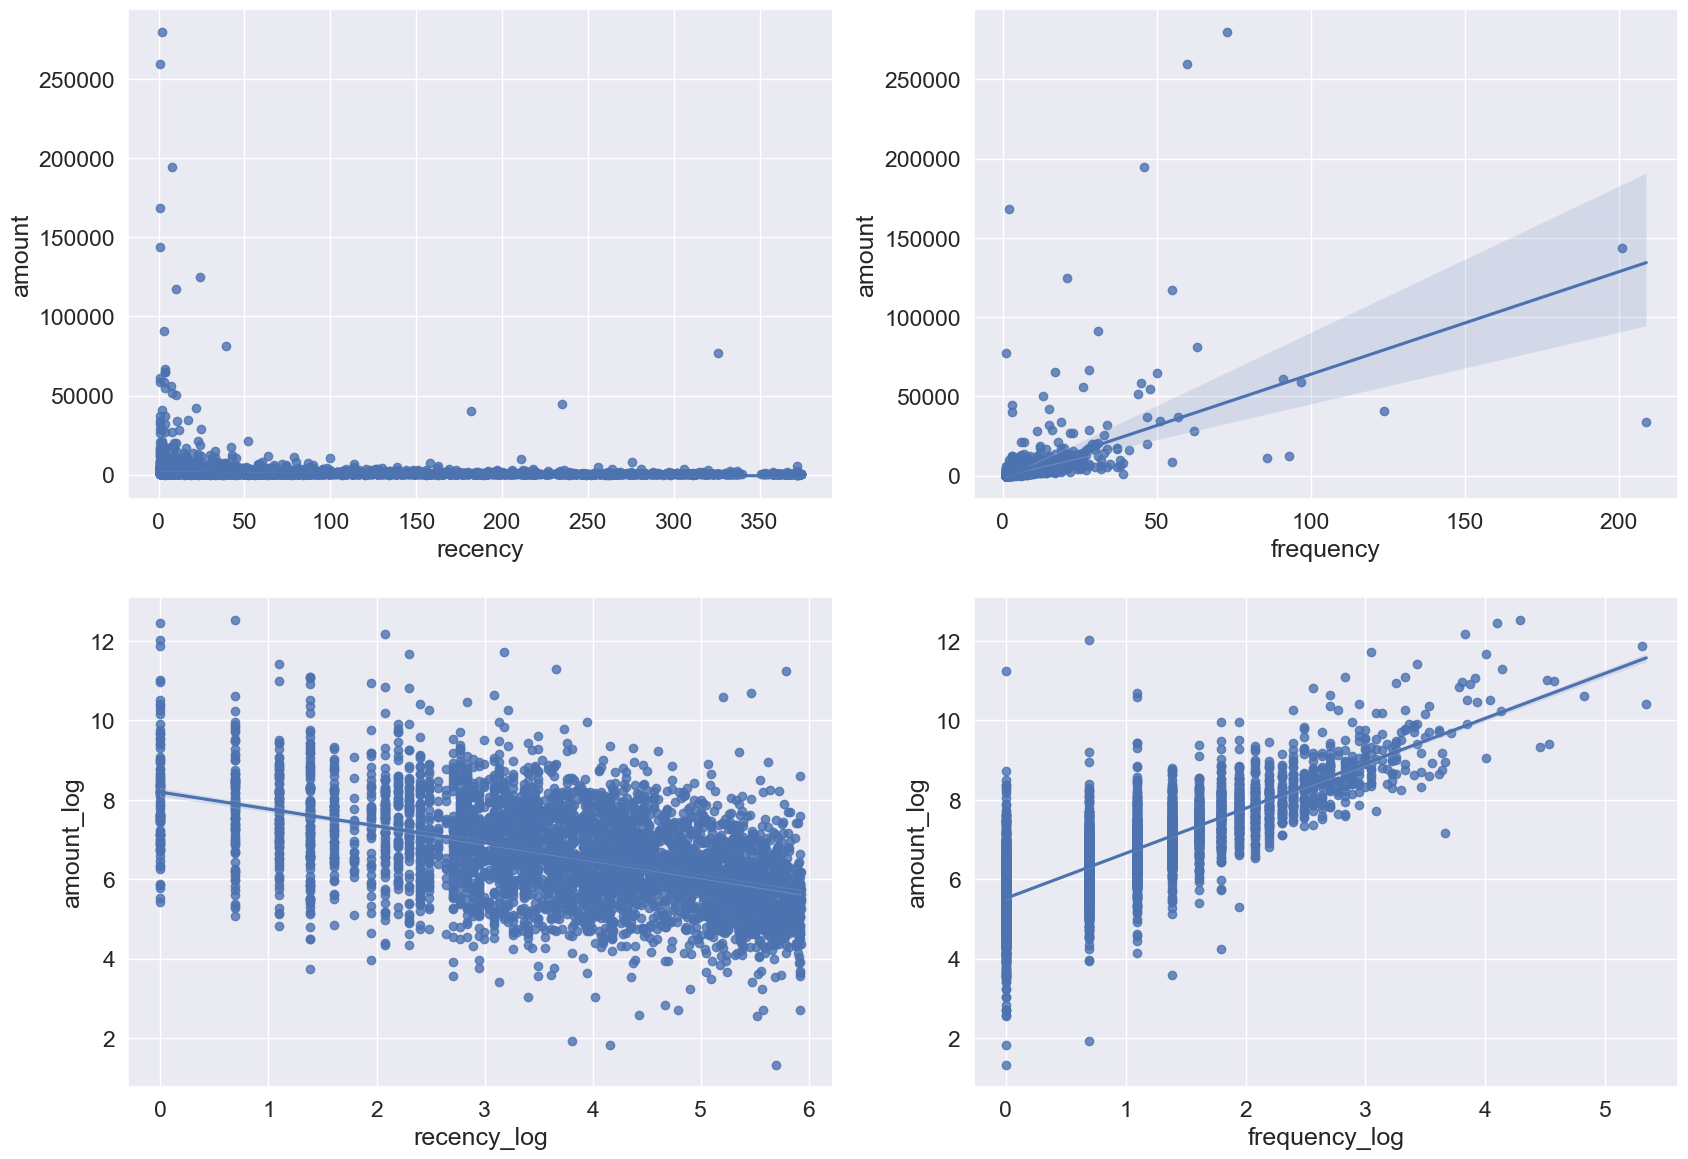

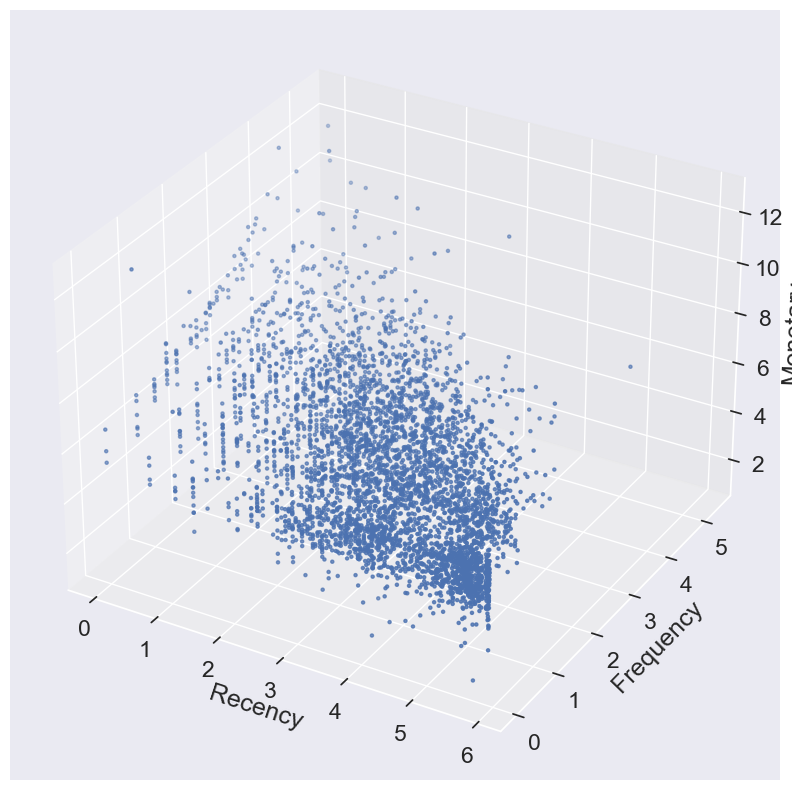

In [22]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

- Chúng ta có thể thấy từ các biểu đồ ở trên
    - Những người mua hàng với tần suất cao hơn (frequency) có xu hướng chi tiêu nhiều hơn (Monetary value) dựa trên xu hướng ngày càng tăng của số tiền với xu hướng tăng cho Tần suất.
    - Những người mua hàng với truy cập gần đây hơn (recency ) có xu hướng chi tiêu nhiều hơn (Monetary value) dựa trên xu hướng ngày càng tăng của số tiền với xu hướng giảm lần truy cập gần đây.

# Modeling

In [23]:
df_scaler.shape

(4338, 3)

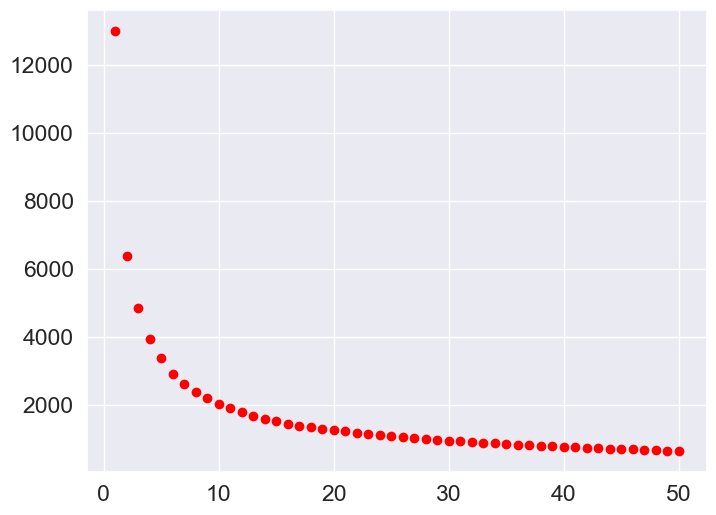

The best K sugest:  7


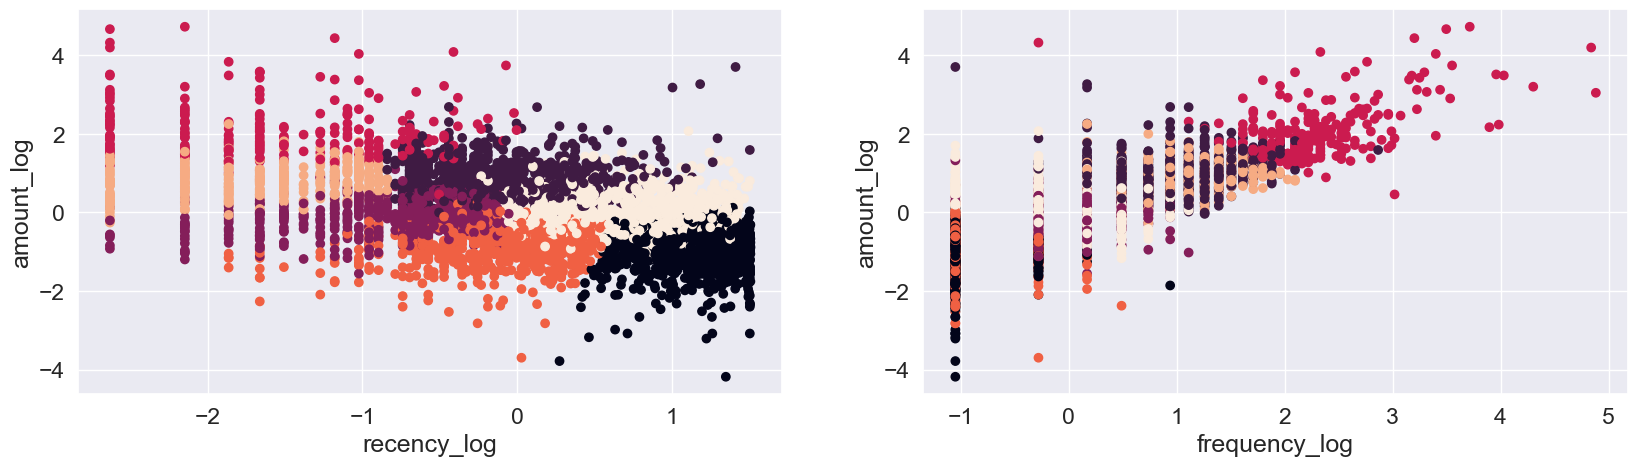

In [24]:
X_scaled = df_scaler.values
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1    
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel('recency_log')
ax.set_ylabel('amount_log')
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel('frequency_log')
ax.set_ylabel('amount_log')

plt.show()

Khi sử dụng phương pháp Elbow bắt đầu với K bằng 3, chúng ta quan sát thấy với k = 7 thì độ giảm phương sai của cụm mạnh nhất với 10%. Từ đặc điểm này nên chúng ta sẽ bắt đầu đánh giá sâu hơn với k từ 3 đến 7. Chúng ta sẽ sử dụng phương pháp phân tích Silhouette.

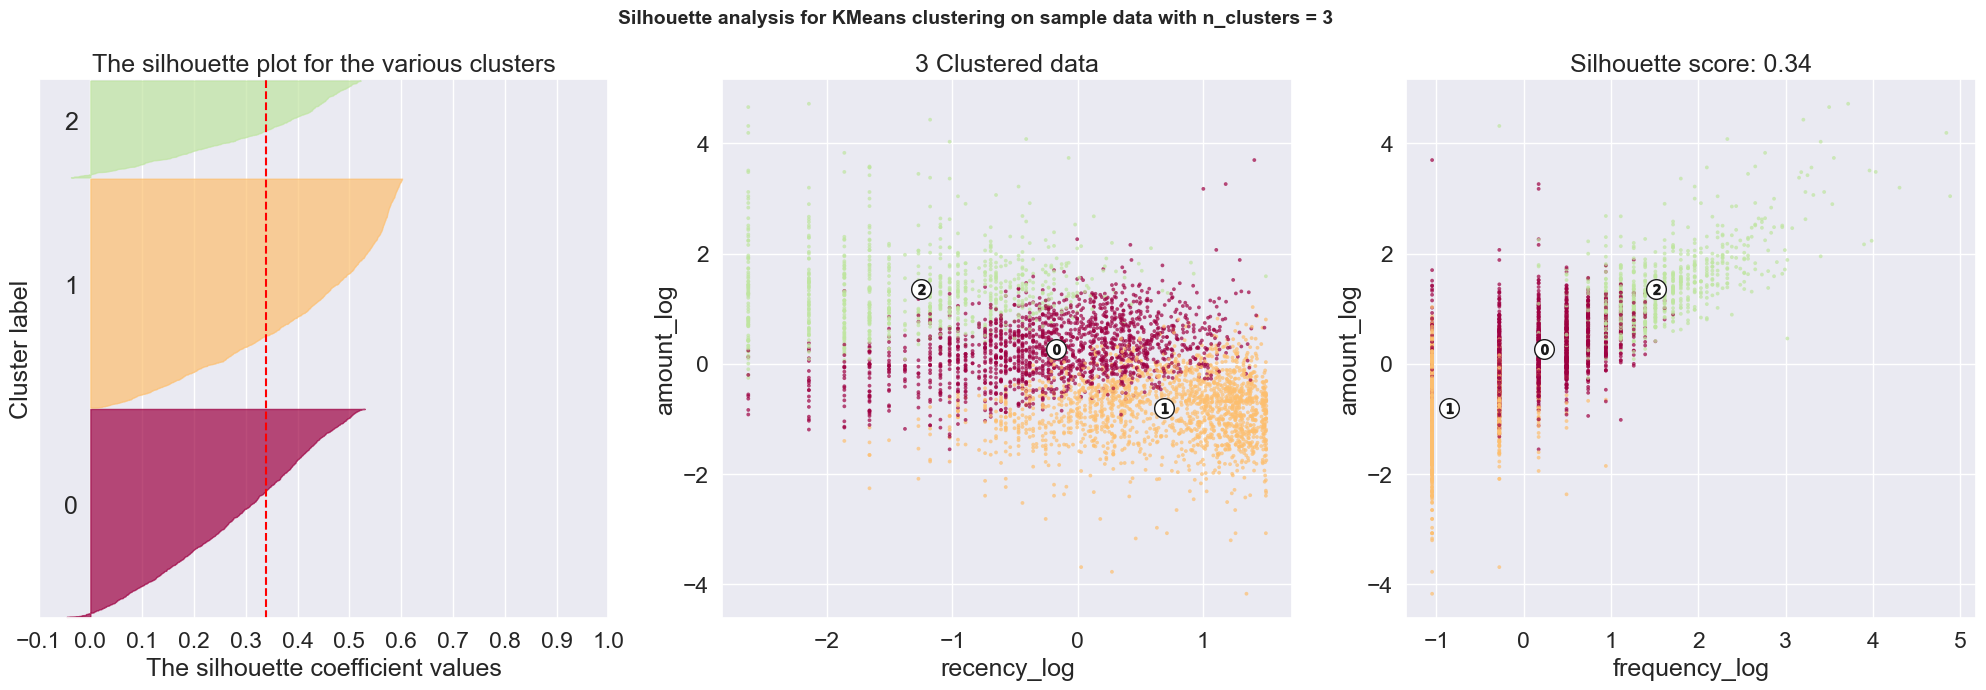

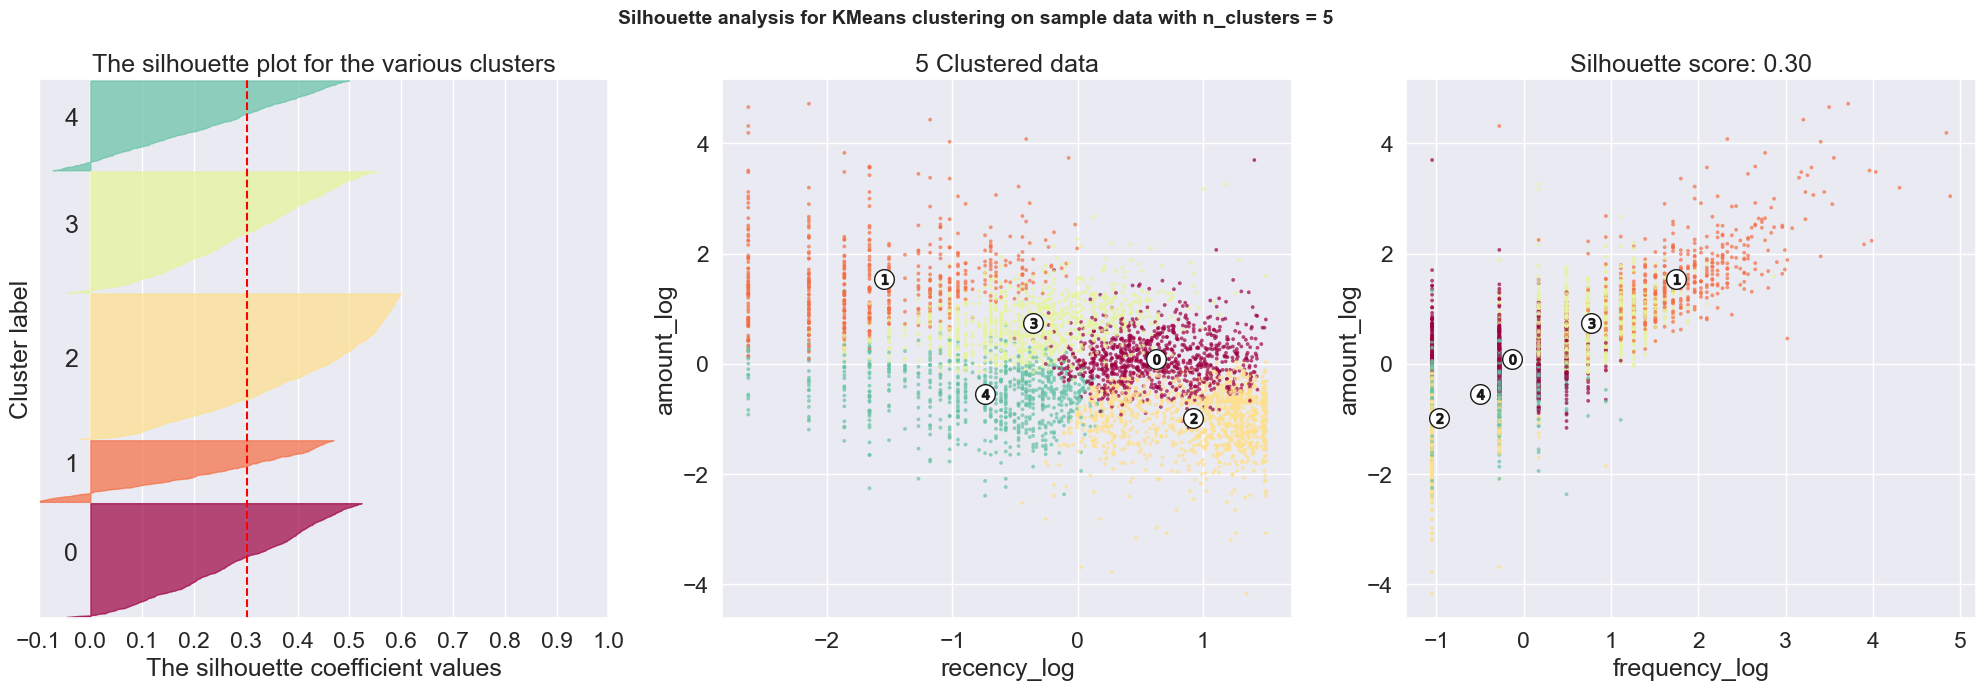

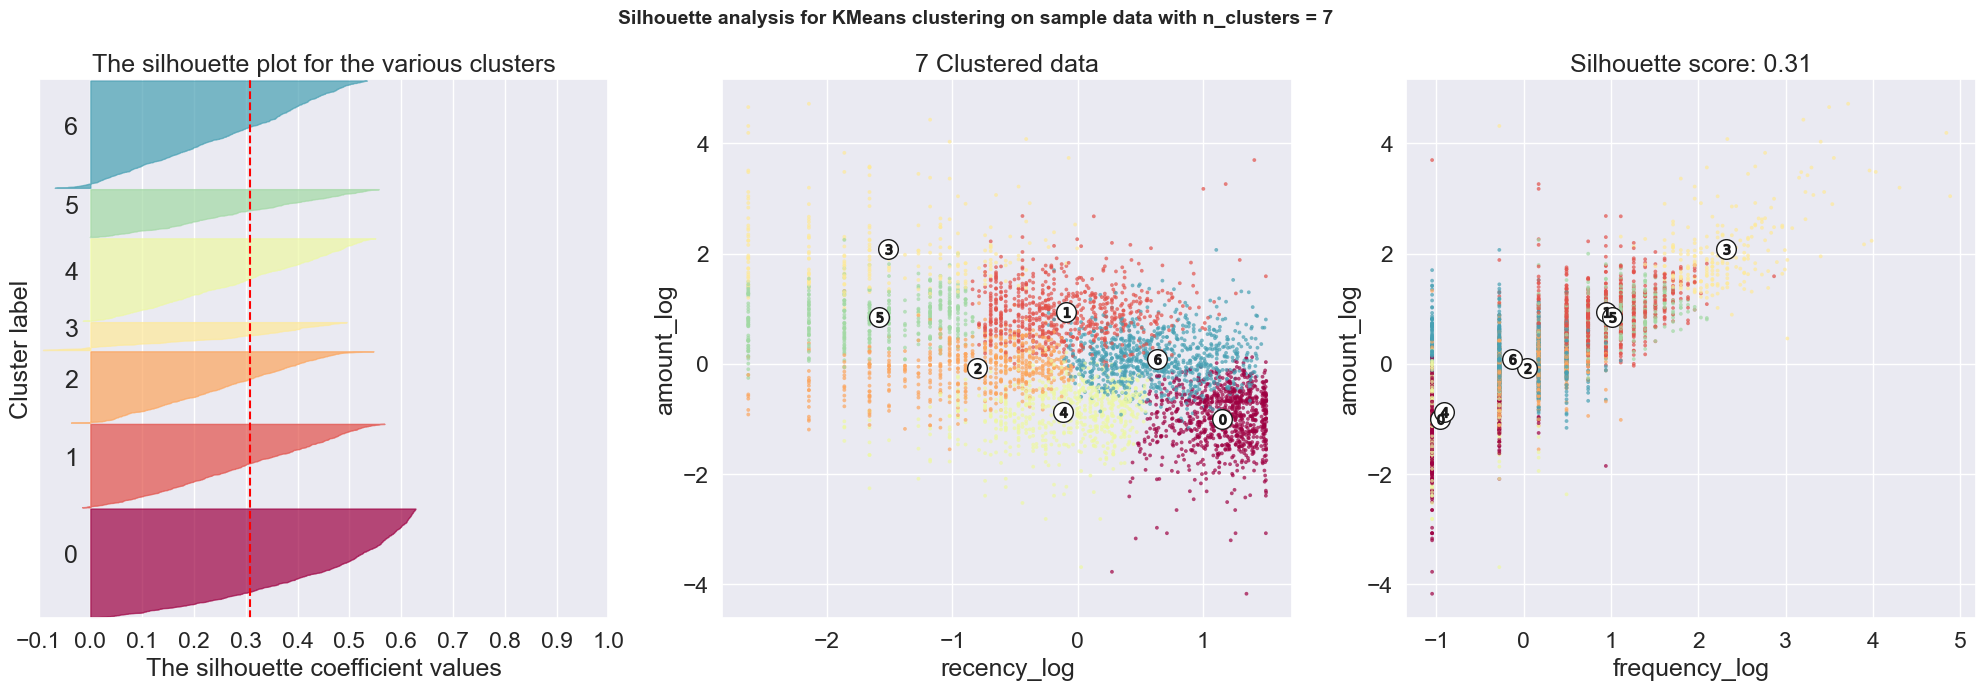

In [25]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):        
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        ith_cluster_silhouette_values.sort()        

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel('recency_log')
    ax2.set_ylabel('amount_log')

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel('frequency_log')
    ax3.set_ylabel('amount_log')
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

- Trong 3 trường hợp n_cluster = 3,5,7 thì Silhouette score dao động trong khoảng 0.30 -> 0.34 là tương đối tốt, điều này có nghĩa là mỗi nhóm khách hàng tạo ra có sự phân tách tốt, mỗi nhóm có tính đồng nhất khá tốt ở bên trong.
- Trong trường hợp n_cluster = 3 chúng ta nhận thấy hình ảnh trực quan khá rõ ràng tại biểu đồ silhouette plot biểu diễn các silhouette coefficient values có xu hướng gần 0 nhiều hơn, điều này có nghĩa là phần lớn các điểm dữ liệu đều có vẻ cách xa tâm cụm và nằm ở phía đường biên của cụm nhiều hơn, khi các điểm dữ liệu có xu hướng nằm gần đường biên thì chúng ta cũng có thể hiểu là các nhóm đang được phân chia chưa được rõ ràng, các điểm nằm ở nhóm này nhưng lại rất gần với nhóm gần kề. Xu hướng này giảm dần tại trường hợp n_cluster = 5 và đến n_cluster = 7 chúng ta nhận thấy các điểm dữ liệu thuộc từng cụm thì số lượng những điểm dữ liệu gần đường biên đã ít đi nhiều. Điều này chứng tỏ các điểm dữ liệu đã được phân nhóm rõ ràng, rành mạch hơn với các điểm thuộc cụm khác, và các điểm trong cùng 1 cụm đã gần nhau hơn.
- Chúng ta có thể quan sát đường màu đỏ, đường màu đỏ là giá trị silhouette trung bình của toàn bộ dữ liệu, chúng ta nhận thấy tại trường hợp n_cluster = 3 thì phần lớn các điểm dữ liệu của các cụm có xu hướng nằm xa đường màu đỏ, tuy nhiên đến trường hợp n_cluster = 7, các điểm dữ liệu của từng cụm có xu hướng nằm gần đường màu đỏ nhiều hơn, điều này chứng tỏ độ phân tách giữa các cụm đã tốt hơn.
- Chúng ta cũng có thể quan sát biểu đồ scater RFM khá rõ ràng trường hợp n_cluster = 7 các điểm dữ liệu của các cụm đã gần tâm cụm hơn và chúng khá tách bạch so với các điểm dữ liệu của cụm khác.

##  Clusters Center

In [26]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
        amount     recency  frequency
0  1019.114007   33.637514   3.171771
1   262.853859  115.772727   1.196009
2  3983.322212    7.173427  10.099071
--------------------------------------------------
for 5 clusters the silhouette score is 0.30
Centers of each cluster:
        amount     recency  frequency
0   813.621211  105.524342   2.279822
1  5051.937209    4.728829  12.403678
2   208.013492  162.151056   1.075721
3  1830.850445   25.873099   5.126046
4   366.981282   15.050233   1.644625
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
         amount     recency  frequency
0    205.487848  225.646442   1.084052
1   2401.476039   37.751906   6.002805
2    657.936736   13.675696   2.647270
3  10143.118638    4.926439  20.646017
4    239.411000   36.717710   1.130641
5   2114.266897    4.458579   6.365225
6    814.574493  107.556965   2.277767

# 5. Clusters Insights

1) **Trường hợp có 3 cụm:**
- Cụm 1: Trung bình số lượng giao dịch và tần suất mua hàng trung bình, nhưng khoảng cách từ lần mua hàng gần nhất đến ngày tham chiếu (recency) trung bình. => `Level 2`
- Cụm 2: Trung bình số lượng giao dịch và tần suất mua hàng thấp, và khoảng cách recency cao. => `Level 3`
- Cụm 3: Có số lượng giao dịch và tần suất mua hàng cao, và khoảng cách recency thấp. => `Level 1`

2) **Trường hợp có 5 cụm:**
- Cụm 1: Số lượng giao dịch và tần suất mua hàng thấp 3, khoảng cách recency cao 2. => `Level 3`
- Cụm 2: Số lượng giao dịch và tần suất mua hàng cao, và khoảng cách recency thấp. => `Level 1`
- Cụm 3: Số lượng giao dịch và tần suất mua hàng thấp 1, và khoảng cách recency cao 1. => `Level 5`
- Cụm 4: Số lượng giao dịch và tần suất mua hàng trung bình, và khoảng cách recency trung bình. => `Level 2`
- Cụm 5: Số lượng giao dịch và tần suất mua hàng thấp 2, và khoảng cách recency trung bình. => `Level 4`

3) **Trường hợp có 7 cụm:**
- Cụm 1: Số lượng giao dịch và tần suất mua hàng thấp nhất, khoảng cách recency rất cao. => `Level 7`
- Cụm 2: Số lượng giao dịch và tần suất mua hàng cao, và khoảng cách recency thấp. => `Level 2`
- Cụm 3: Số lượng giao dịch và tần suất mua hàng thấp thứ 3, và khoảng cách recency thấp. => `Level 5`
- Cụm 4: Số lượng giao dịch và tần suất mua hàng cao nhất, khoảng cách recency rất thấp. => `Level 1`
- Cụm 5: Số lượng giao dịch và tần suất mua hàng thấp thứ 2, khoảng cách recency khá cao. => `Level 6`
- Cụm 6: Số lượng giao dịch và tần suất mua hàng thấp, khoảng cách recency thấp. => `Level 3`
- Cụm 7: Số lượng giao dịch và tần suất mua hàng trung bình, khoảng cách recency cao. => `Level 4`

**Note!!!: `Level 1` là khách hàng cao cấp** 

In [33]:
# Add labels to data
clusters = ['clusters_3', 'clusters_5', 'clusters_7']
for clus, n_clusters in zip(clusters, range(3,K_best+1,2)):
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)
    customer_history_df[clus] = cluster_labels
customer_history_df.head()

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log,clusters_3,clusters_5,clusters_7
0,12346,326,1,77183.60,5.786897,0.000000,11.253942,0,0,1
1,12347,2,7,4310.00,0.693147,1.945910,8.368693,2,1,5
2,12348,75,4,1797.24,4.317488,1.386294,7.494007,0,3,1
3,12349,19,1,1757.55,2.944439,0.000000,7.471676,0,4,2
4,12350,310,1,334.40,5.736572,0.000000,5.812338,1,2,0


In [38]:
customer_history_df['clusters_3'].value_counts()

clusters_3
1    1860
0    1691
2     787
Name: count, dtype: int64

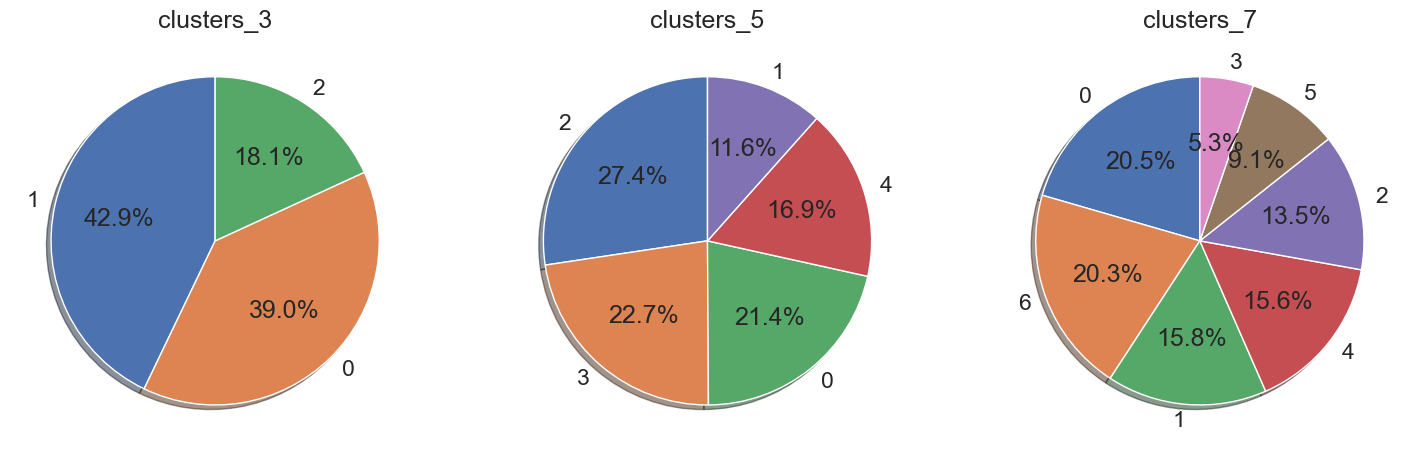

In [28]:
cols = ['clusters_3', 'clusters_5', 'clusters_7']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Tạo ra hình vẽ với 1 hàng và 3 cột
for i, c in enumerate(cols):
    customer_history_df[c].value_counts().plot(kind='pie', ax=axes[i], autopct='%1.1f%%', shadow=True, startangle=90)
    axes[i].set_title(c)  # Thiết lập tiêu đề cho từng subplot
    axes[i].set_ylabel('')  # Loại bỏ nhãn trục y
plt.show()

### Nhận xét
- Trường hợp chúng ta phân khúc khách hàng thành 3 nhóm thì nhóm khách hàng ở phân khúc thấp nhất là nhóm 1 chiếm khoảng 42.9%, nhóm cao nhất chiếm khoảng 18.1% trên tổng số khách hàng của công ty.
- Trường hợp chúng ta phân khúc khách hàng thành 5 nhóm thì nhóm khách hàng ở phân khúc thấp nhất là nhóm 2 chiếm khoảng 27.4%, nhóm cao nhất là nhóm 1 chiếm khoảng 11.6% trên tổng số khách hàng của công ty.
- Trường hợp chúng ta phân khúc khách hàng thành 7 nhóm thì nhóm khách hàng ở phân khúc thấp nhất là nhóm 0 chiếm khoảng 20.5%, nhóm cao nhất là nhóm 3 chiếm khoảng 5.3% trên tổng số khách hàng của công ty.

In [29]:
customer_history_df.head()

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log,clusters_3,clusters_5,clusters_7
0,12346,326,1,77183.60,5.786897,0.000000,11.253942,0,0,1
1,12347,2,7,4310.00,0.693147,1.945910,8.368693,2,1,5
2,12348,75,4,1797.24,4.317488,1.386294,7.494007,0,3,1
3,12349,19,1,1757.55,2.944439,0.000000,7.471676,0,4,2
4,12350,310,1,334.40,5.736572,0.000000,5.812338,1,2,0


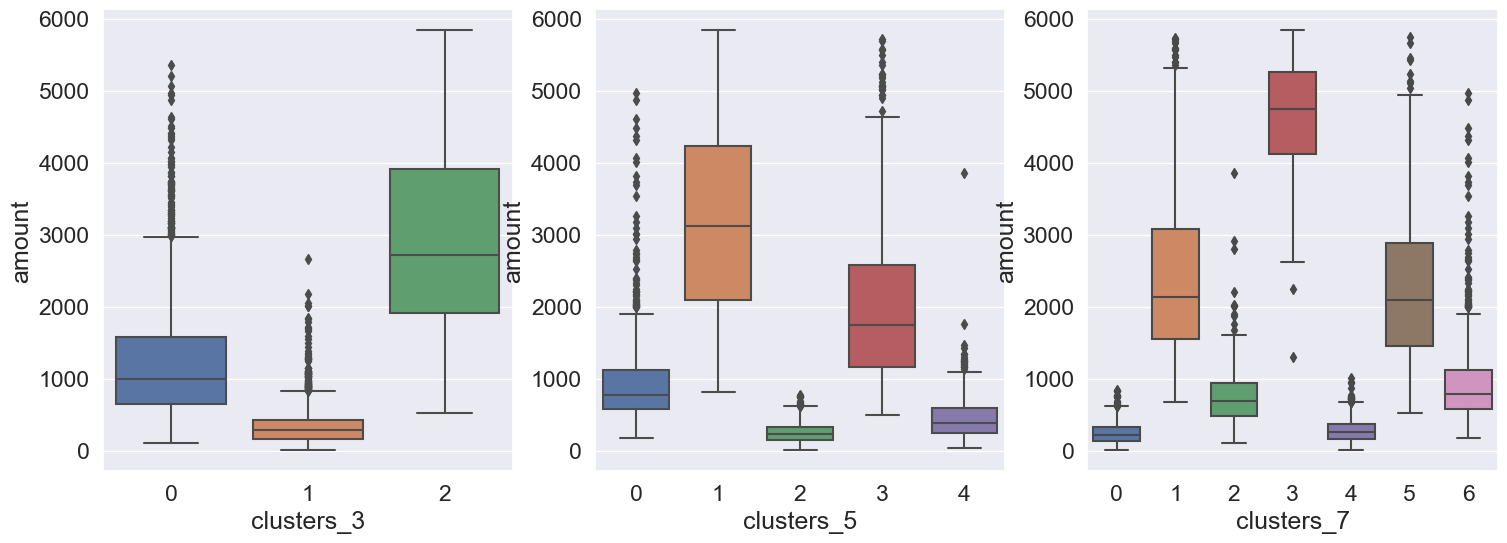

In [30]:
# Xác định giới hạn trên dựa trên quantile 0.95
q_high = customer_history_df['amount'].quantile(0.95)
customer_history_df_filtered = customer_history_df[customer_history_df['amount'] < q_high]
# Ve bieu do
col = ['clusters_3', 'clusters_5', 'clusters_7']
fig, axes = plt.subplots(1,3, figsize = (18,6))
for i, c in enumerate(col):
    sns.boxplot(x = c, y = 'amount', data = customer_history_df_filtered, ax=axes[i])
    
plt.show()

### Nhận xét
- Chúng ta nhận thấy có nhiều giá trị ngoại lai của các nhóm, điều này chứng tỏ có sự biến động lớn trong dữ liệu, có thể có các điểm dữ liệu không phù hợp có thể làm thay đổi phân phối của nhóm.
- Giá trị ngoại lai xuất hiện trong các nhóm khác nhau, điều này chứng tỏ có sự đa dạng trong các nhóm, 1 số nhóm có dữ liệu gần nhau, tuy nhiên có 1 số nhóm lại có những điểm dữ liệu khác biệt.
- Trong trường hợp K = 3, tại nhóm 0 chúng ta thấy có rất nhiều điểm dữ liệu nằm ở xa phân phối trung tâm, những điểm dữ liệu ngoại lai này là những khách hàng mua hàng với chi phí cao của công ty, thậm chí giá trị mua hàng của những khách hàng này còn cao hơn cả khách hàng thuộc nhóm 2(là phân khúc cao) nhưng lại chỉ được xếp vào phân khúc khách hàng trung bình.
- Tương tự với trường hợp K = 5 thì nhóm 0 và nhóm 5 cũng có những giá trị amount cao, nhưng lại được xếp vào phân khúc trung bình và thấp
- Trường hợp K = 7 cũng có tồn tại những điểm dữ liệu nằm ở xa phân phối trung tâm của nhóm, tuy nhiên có vẻ như các nhóm đã trở nên rõ ràng, rành mạch hơn.
- Giá trị ngoại lai có thể gây ảnh hưởng lớn đến phân tích thống kê, do đó chúng ta có thể xem xét lại dữ liệu 1 cách cẩn thận và cân nhắc các giải pháp.
- Việc lựa chọn việc chia làm 3, 5 hay 7 nhóm còn tùy thuộc vào bài toán kinh doanh của doanh nghiệp.
- Việc hiểu dữ liệu, hiểu các nhóm tồn tại các giá trị ngoại lai cũng giúp doanh nghiệp có cái nhìn rõ ràng hơn về bài toán thực tế.

# ** """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""" **